In [1]:
# Imports
import sys
import logging
import os
from collections import OrderedDict
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import EventStorage
import cv2
import pickle
from detectron2.structures import BoxMode
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T

In [2]:
# Custom HubMap Dataset
class HubMapDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'all_dataset1_imgs')
        self.annotation_dir = os.path.join(data_dir, 'sample_dataset1_annotations')
        self.image_file_list = os.listdir(self.image_dir)
        self.annotation_file_list = os.listdir(self.annotation_dir)
        
    def __len__(self):
        return len(self.image_file_list)
        
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_file_list[idx])
        annotation_path = os.path.join(self.annotation_dir, self.annotation_file_list[idx])
        
        image = cv2.imread(image_path)
        height, width = image.shape[:2]
        
        record = {
            'file_name': image_path,
            'image_id': idx,
            'height': height,
            'width': width,
        }
        
        with open(annotation_path, 'rb') as f:
            orig_annots = pickle.load(f)
        
        objs = []
        for orig_annot in orig_annots:
            orig_annot['bbox_mode'] = BoxMode.XYWH_ABS
            objs.append(orig_annot)
            
        record['annotations'] = objs
        
        return record

In [3]:
# Function to register a dataset
def register_custom_dataset(dataset_name, data_dir):
    DatasetCatalog.register(dataset_name, lambda: HubMapDataset(data_dir))
    MetadataCatalog.get(dataset_name).set(thing_classes=['blood_vessel'], evaluator_type="coco")

In [4]:
class CustomArguments:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [5]:
# arguments
config_file = '/home/ec2-user/hubmap-hacking-the-human-vasculature/project_detectron2/custom_configs/maskrcnn_with_resnet_50.yaml'
num_machines = 1
num_gpus = 0
machine_rank = 0
port = 2**15 + 2**14 + hash(os.getuid() if sys.platform != "win32" else 1) % 2**14
dist_url = "tcp://127.0.0.1:{}".format(port)
opts = []
argument_dict = {'config_file':config_file, 'num_machines':num_machines, 'num_gpus':num_gpus, 'machine_rank': machine_rank, 'dist_url':dist_url, 'opts': opts}
args = CustomArguments(**argument_dict)

In [6]:
# Setup the config
cfg = get_cfg()
cfg.merge_from_file(args.config_file)
cfg.merge_from_list(args.opts)
cfg.freeze()
default_setup(
    cfg, args
)

Config '/home/ec2-user/hubmap-hacking-the-human-vasculature/project_detectron2/custom_configs/maskrcnn_with_resnet_50.yaml' has no VERSION. Assuming it to be compatible with latest v2.


[06/09 08:38:54 detectron2]: Rank of current process: 0. World size: 1
[06/09 08:38:55 detectron2]: Environment info:
-------------------------------  ------------------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.10.11 | packaged by conda-forge | (main, May 10 2023, 18:58:44) [GCC 11.3.0]
numpy                            1.24.1
detectron2                       0.6 @/home/ec2-user/hubmap-hacking-the-human-vasculature/detectron2/detectron2
Compiler                         GCC 7.3
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.0.1+cpu @/home/ec2-user/anaconda3/envs/detectron_env/lib/python3.10/site-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    No: torch.cuda.is_available() == False
Pillow                           9.3.0
torchv

[06/09 08:38:55 detectron2]: Full config saved to output/config.yaml
[06/09 08:38:55 d2.utils.env]: Using a generated random seed 55538946


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [7]:
model = build_model(cfg)

In [8]:
model

GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
      (1): BottleneckBlock(

In [9]:
# Training Loop
model.train()
resume = False
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
if "hubmap-dataset-1" not in MetadataCatalog.list():
    register_custom_dataset('hubmap-dataset-1', '/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files')
data_transforms = [
#     T.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=90),
#     T.ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=0),
#     T.ShiftScaleRotate(shift_limit=0, scale_limit=0.2, rotate_limit=0),
#     T.RandomFlip(prob=0.5, horizontal=True, vertical=True),
#     T.BrightnessTransform(prob=0.5, delta=0.2),
    T.RandomRotation([-90,90], expand=True),
    T.RandomFlip(horizontal=True, vertical=False),
    T.RandomFlip(horizontal=False, vertical=True),
    T.RandomBrightness(0.8, 1.2),
    T.RandomContrast(0.8, 1.2),
    T.RandomSaturation(0.8,1.2),
    T.RandomCrop(crop_type='relative_range', crop_size=(0.8,0.8))
]
data_loader = build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations=data_transforms))

[06/09 08:38:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-50.pkl ...
[06/09 08:38:56 fvcore.common.checkpoint]: [Checkpointer] Loading from /home/ec2-user/.torch/iopath_cache/detectron2/ImageNetPretrained/MSRA/R-50.pkl ...
[06/09 08:38:56 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[06/09 08:38:56 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model              | Names in Checkpoint      | Shapes                                          |
|:----------------------------|:-------------------------|:------------------------------------------------|
| backbone.res2.0.conv1.*     | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.res2.0.conv2.*     | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.res2.0.conv3.*     | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)    

[06/09 08:38:56 d2.data.common]: Serialized dataset takes 0.03 MiB


In [10]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

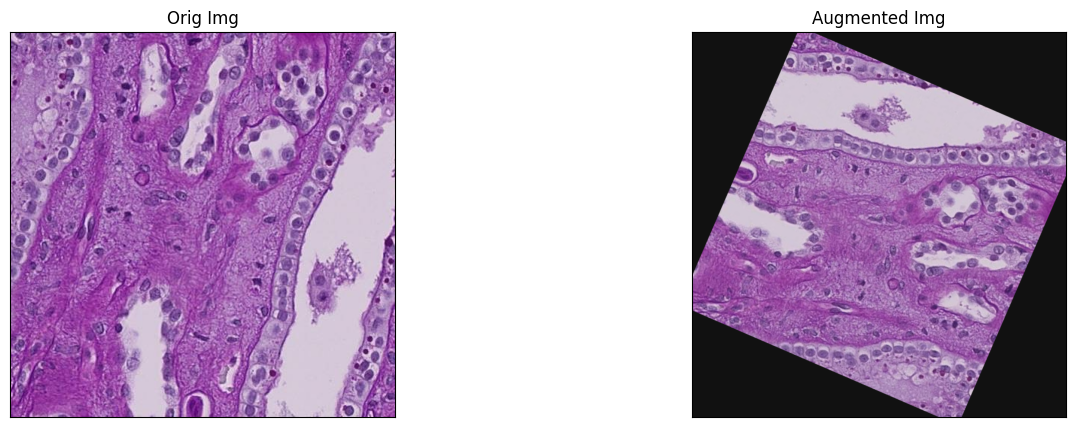

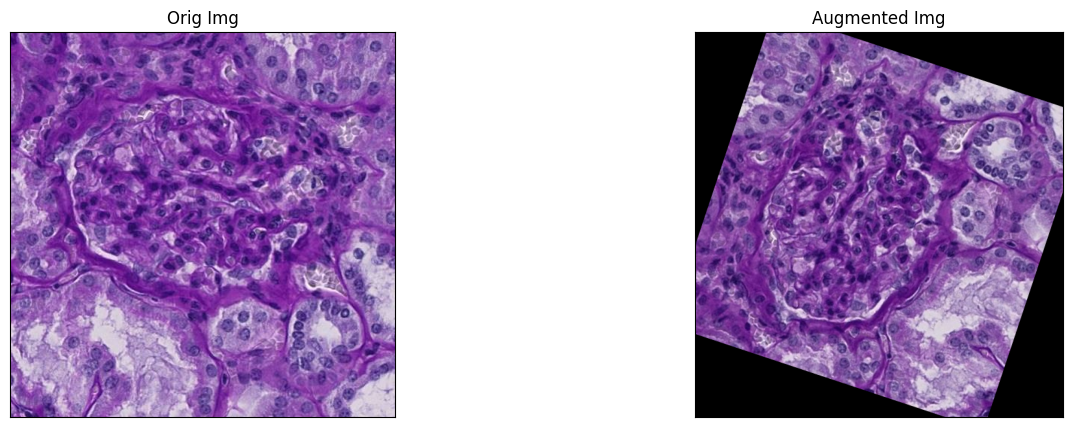

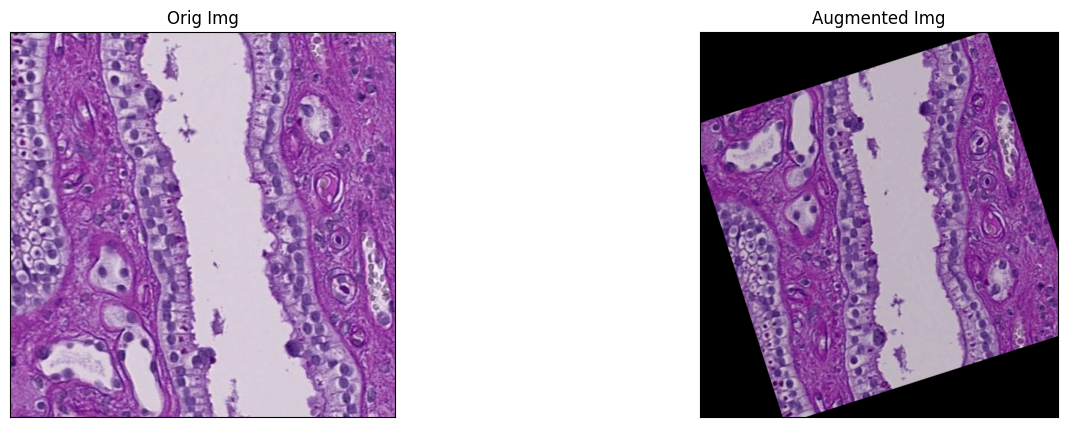

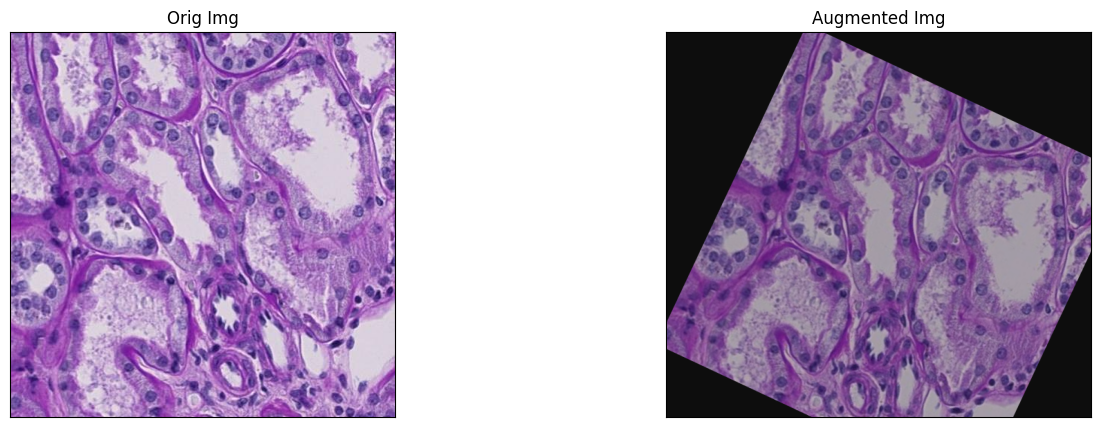

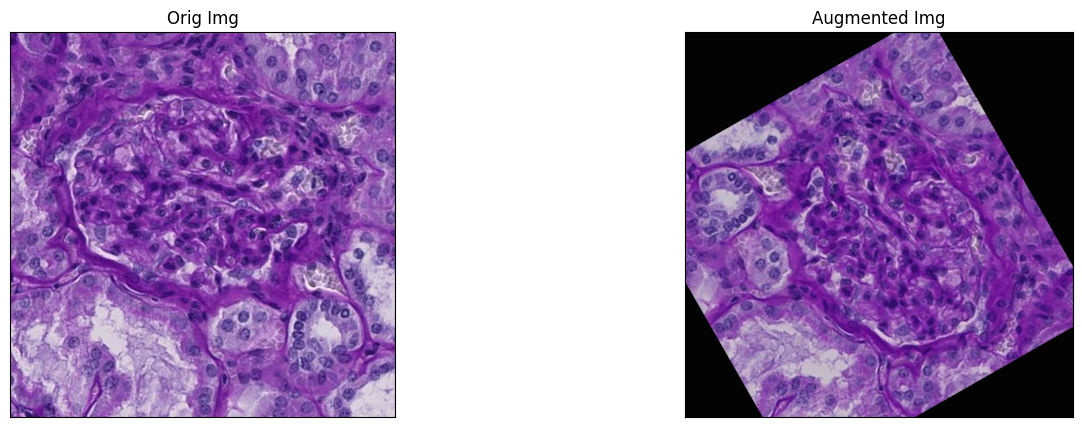

In [11]:
import matplotlib.pyplot as plt
for data, iteration in zip(data_loader, range(start_iter, start_iter+5)):
    image_dict = dict()
    file_path = data[0]['file_name']
    orig_img = cv2.imread(file_path)
#     orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    augmented_img = data[0]['image'].transpose(1,0).transpose(1,2)
    image_dict['orig_img'] = orig_img
    image_dict['augmented_img'] = augmented_img
    visualize(**image_dict)

In [12]:
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, start_iter+1)):
        loss_dict = model(data)
        print(loss_dict)

/home/ec2-user/anaconda3/envs/detectron_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'loss_cls': tensor(4.3254, grad_fn=<MulBackward0>), 'loss_box_reg': tensor(0.1607, grad_fn=<MulBackward0>), 'loss_mask': tensor(0.6922, grad_fn=<MulBackward0>), 'loss_rpn_cls': tensor(0.6977, grad_fn=<MulBackward0>), 'loss_rpn_loc': tensor(0.0296, grad_fn=<MulBackward0>)}


In [13]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)


In [15]:
if "hubmap-dataset-1" not in MetadataCatalog.list():
    register_custom_dataset('hubmap-dataset-1', '/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files')
results = OrderedDict()
for dataset_name in cfg.DATASETS.TEST:
    data_loader = build_detection_test_loader(cfg, dataset_name)
    evaluator = get_evaluator(
        cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
    )
    results_i = inference_on_dataset(model, data_loader, evaluator)
    results[dataset_name] = results_i
    if comm.is_main_process():
        print_csv_format(results_i)
if len(results) == 1:
    results = list(results.values())[0]

[06/09 08:40:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/09 08:40:41 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/09 08:40:41 d2.data.common]: Serializing 4 elements to byte tensors and concatenating them all ...
[06/09 08:40:41 d2.data.common]: Serialized dataset takes 0.03 MiB
[06/09 08:40:42 d2.evaluation.evaluator]: Start inference on 4 batches
[06/09 08:40:53 d2.evaluation.evaluator]: Inference done 1/4. Dataloading: 0.1855 s/iter. Inference: 10.9050 s/iter. Eval: 0.0585 s/iter. Total: 11.1497 s/iter. ETA=0:00:33
[06/09 08:41:03 d2.evaluation.evaluator]: Inference done 2/4. Dataloading: 0.0936 s/iter. Inference: 10.7236 s/iter. Eval: 0.0438 s/iter. Total: 10.8623 s/iter. ETA=0:00:21
[06/09 08:41:14 d2.evaluation.evaluator]: Inference done 3/4. Dataloading: 0.0629 s/iter. Inference: 10.6709 s/iter.

In [16]:
results

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': 0.0}),
             ('segm',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': 0.0})])